In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import random
import time
from pprint import pprint
from itertools import count
from gym import spaces
from collections import OrderedDict, deque
from tqdm import tqdm
from operator import add
from torch.distributions import Categorical
import torch.nn.functional as F
# torch.autograd.set_detect_anomaly(True)
%matplotlib inline

In [6]:
# !pip3 install box2d-py
# !pip3 install gym[Box_2D]

In [23]:
class DQNnet(nn.Module):
    '''
    DQNnet is a class that defines the Q-net
    '''
    def __init__(self, input_size, output_size, lr):
        super(DQNnet, self).__init__()
        self.hl1_size = 256
        self.hl2_size = 256
#         self.hl3_size = 32
        self.linear_model = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(input_size, self.hl1_size)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(self.hl1_size, self.hl2_size)),
            ('relu2', nn.ReLU()),
#             ('dense3', nn.Linear(self.hl2_size, self.hl3_size)),
#             ('relu3', nn.ReLU()),
            ('dense3', nn.Linear(self.hl2_size, output_size))]
        ))
        self.optimizer = optim.Adam(self.parameters())
    
    def forward(self, x):
        '''
        Perform forward pass in the network
        '''
        x = self.linear_model(x)
        return x

In [29]:
class DQNagent:
    '''
    DQNagent is a class that defines the agent.
    '''
    def __init__(self, state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len):
        '''
        Initialize all the parameters that will be used in the learning phase.
        Initital two DQN networks - one is the policy network and the other is the target network
        '''
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=memory_len)
        
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.001
        self.batch_size = batch_size
        self.learning_rate = lr
        self.discount_factor = discount_factor
        
        # self.device = 'cpu'
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.policy_net = DQNnet(self.state_size, self.action_size, self.learning_rate).to(self.device)
        self.target_net = DQNnet(self.state_size, self.action_size, self.learning_rate).to(self.device)
        self.update_target_policy()
        
    def get_action(self, current_state_vector):
        '''
        This function defines epsilon greedy behavior of the agent.
        '''
        rand_num = np.random.random()
        if rand_num < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            if not torch.is_tensor(current_state_vector):
                current_state_vector = torch.from_numpy(current_state_vector).float().to(self.device)
            
            with torch.no_grad():
                q_values = self.policy_net.forward(current_state_vector).view(-1,)
            best_action = torch.argmax(q_values).item()
        return best_action
    
    def append_memory(self, state, action, reward, next_state, done):
        '''
        Save each experience in the replay memory
        '''
        self.memory.append((state, action, reward, next_state, done))
    
    def update_target_policy(self):
        '''
        Update the target network parameters based on the policy network parameters
        '''
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def update_epsilon(self):
        '''
        Perform epsilon decay
        '''
        self.epsilon -= (self.epsilon * self.epsilon_decay)
        return self.epsilon
    
    def train_model(self):
        '''
        Train the agent
        '''
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            current_state = list()
            actions = list()
            rewards = list()
            next_states = list()
            dones = list()
            
            # Append each memory values in the separate lists
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                current_state.append(state)
                actions.append(action)
                rewards.append(reward)
                next_states.append(next_state)
                dones.append(done_boolean)
            
            # Convert each list to torch tensors
            current_state = torch.from_numpy(np.array(current_state)).float().to(self.device)
            actions = torch.from_numpy(np.array(actions)).to(self.device)
            rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
            next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
            dones = torch.from_numpy(np.array(dones)).to(self.device)

            # Make a forward pass in the policy network based on the current state
            # and choose the q-value of the action
            policy_q_values = self.policy_net.forward(current_state).gather(1, actions.view(-1,1)).view(-1,)

            # Make a forward pass in the target network based on the next state
            # and choose the q-value of the action which gives the highest q-value
            target_q_values = self.target_net.forward(next_states).max(dim=1).values
            
            # Compute the target
            y_target = list()
            for index, value in enumerate(target_q_values):
                if dones[index]:
                    y_target.append(rewards[index])
                else:
                    y_target.append(rewards[index] + self.discount_factor * value)
            
            y_target = torch.stack(y_target, dim=0) # Create the list to torch tensor

            # Calculate the MSE loss and perform a backward pass in the policy network
            criterion = nn.MSELoss()
            loss = criterion(y_target, policy_q_values)
            self.policy_net.optimizer.zero_grad()
            loss.backward()

            self.policy_net.optimizer.step()
    
    def test_model(self, env, episodes, perform_render=False):
        '''
        Test the agent behavior after it has been trained
        Agent follows only the greedy policy
        '''
        
        # print('\nTesting the agent after it has been trained')
        # print('Agent chooses only greedy actions from the learnt policy')
        
        total_reward_arr = list()
        timesteps = 0
        self.epsilon = 0
        for episode in range(episodes):
            current_state = env.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = self.get_action(current_state)
                next_state, reward, done, info = env.step(action)

                total_reward += reward
                current_state = next_state.copy()
                
                # Render only for the final episode
                if perform_render and episodes-1 == episode:
                    env.render()
            
            total_reward_arr.append(total_reward)
        return total_reward_arr
    
    def save_model(self, filename):
        '''
        Save the trained model
        '''
        torch.save(self.policy_net.state_dict(), filename)
    
    def load_model(self, filename):
        '''
        Load the model
        '''
        self.policy_net.load_state_dict(torch.load(filename))

In [30]:
def plot_graphs(title, total_reward, epsilon_decay, cumulative_reward, avg_timestep, episodes):
    '''
    This functions plots the graphs for rewards, epsilon, success, failure and avergae timesteps
    
    Success is defined when the agent has reached the goal state
    Failure is defined when the agent meets the monster or falls in the pit
    '''
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    fig.suptitle(title, fontsize=18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85, hspace=0.2, wspace=0.2)
    axs[0,0].plot(epsilon_decay)
    axs[0,0].set_title('Epsilon Decay')
    axs[0,0].set_xlabel('Episodes')
    axs[0,0].set_ylabel('Epsilon')
    
    axs[0,1].plot(avg_timestep)
    axs[0,1].set_title('Average timesteps per 50 episodes')
    axs[0,1].set_xticks(np.arange(len(avg_timestep)))
#     axs[0,1].set_xticklabels(list(range(0,episodes+1,50))[1:], rotation=45)
    axs[0,1].set_xlabel('Episodes')
    axs[0,1].set_ylabel('Timesteps')
    
    axs[1,0].plot(total_reward)
    axs[1,0].set_title('Total Reward per episode')
    axs[1,0].set_xlabel('Episodes')
    axs[1,0].set_ylabel('Rewards')
    
    axs[1,1].plot(cumulative_reward)
    axs[1,1].set_title('Cumulative reward over all episodes')
    axs[1,1].set_xlabel('Episodes')
    axs[1,1].set_ylabel('Cumulative Rewards')
    
    plt.show()

In [39]:
# Parameters
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
epsilon = 1.0
epsilon_decay = 0.002
batch_size = 64
lr = 0.001
discount_factor = 0.99
update_frequency = 10
memory_len = 10000
episodes = 5000
test_episodes = 100
perform_render = False

In [ ]:
# Main function where we loop through each episode
# and make the agent explore and then exploit the environment
# to learn the optimal policy

# def main(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len, update_frequency, episodes, test_episodes, perform_render):
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_reward_arr = list() # Store total reward per episode values
cumulative_reward_arr = list() # Store cumulative reward
epsilon_decay_arr = [epsilon] # Store each epsilon value after decay
timestep_arr = list() # Store the timestep per episode
avg_timestep_arr = list() # Store average timestep every 20 episodes
test_total_reward_arr = list()

agent = DQNagent(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len)
success_count = 0
failure_count = 0
train_timestep = 5

for episode in tqdm(range(episodes)):
    done = False
    total_reward = 0
    timesteps = 0
    env = gym.make('Acrobot-v1')
    current_state = env.reset().copy()

    while not done:
        action = agent.get_action(current_state)
        next_state, reward, done, info = env.step(action)

        agent.append_memory(current_state, action, reward, next_state, done)

        if timesteps % train_timestep == 0:
            agent.train_model()

        current_state = next_state.copy()
        total_reward += reward
        timesteps += 1

    if timesteps % update_frequency == 0:
        agent.update_target_policy()

    epsilon = agent.update_epsilon()
    epsilon_decay_arr.append(epsilon)

    timestep_arr.append(timesteps)

    # Calculate average timesteps for 50 timesteps
    if done and (episode+1) % 50 == 0:
        avg_timestep_arr.append(np.average(timestep_arr))
        timestep_arr.clear()

    total_reward_arr.append(total_reward)

    if(np.mean(total_reward_arr[-100:]) > -75):
        break
 
    if len(cumulative_reward_arr) == 0:
        cumulative_reward = total_reward
    else:
        cumulative_reward = cumulative_reward_arr[-1] + total_reward
    cumulative_reward_arr.append(cumulative_reward)

# Test the agent
test_total_reward_arr = agent.test_model(env, test_episodes, perform_render=perform_render)

# Save the model weights
agent.save_model("DQN_acrobot_weights.pth")

#     return total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, test_total_reward_arr

 15%|█▌        | 767/5000 [05:36<16:12,  4.35it/s]

In [ ]:
# # Parameters
# env = gym.make('Acrobot-v1')
# state_size = env.observation_space.shape[0]
# action_size = env.action_space.n
# # epsilon = 1.0
# # epsilon_decay = 0.007
# batch_size = 32
# lr = 0.001
# discount_factor = 0.99
# update_frequency = 10
# memory_len = 5000
# episodes = 5000
# test_episodes = 100
# perform_render = False

In [ ]:
# total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, test_total_reward_arr = main(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len, update_frequency, episodes, test_episodes, perform_render)

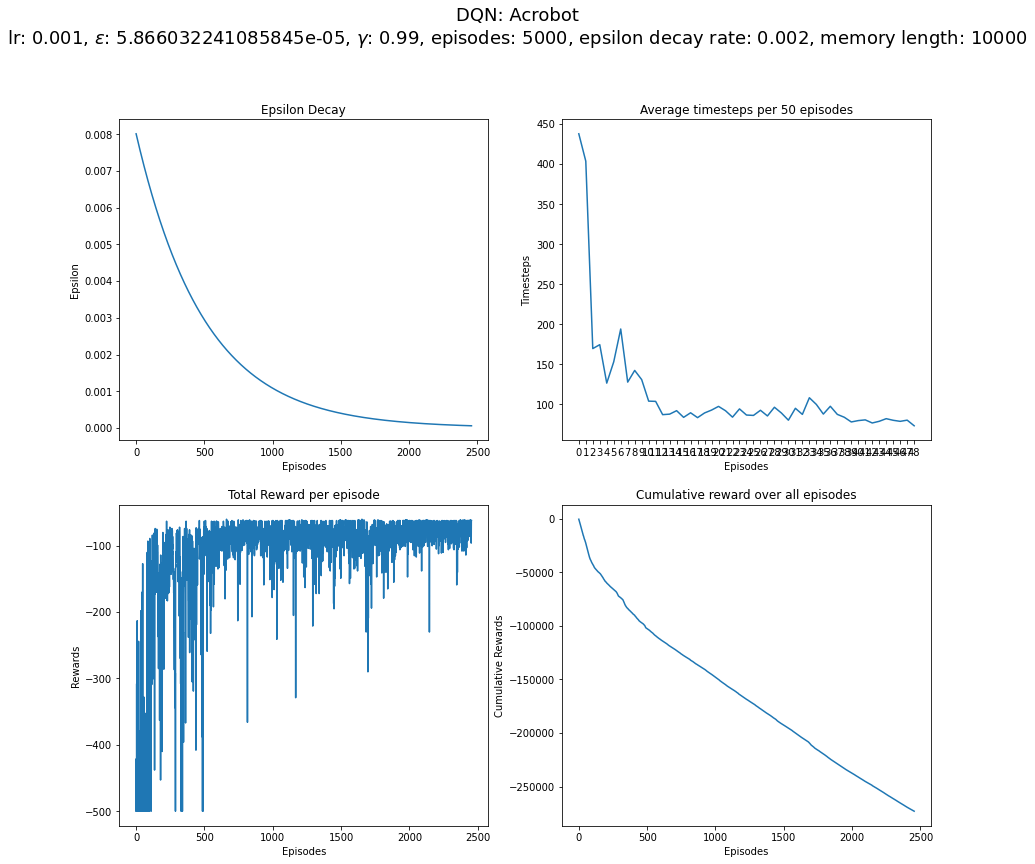

In [44]:
# Plot graphs
title = 'DQN: Acrobot\n' + r'lr: {}, $\epsilon$: {}, $\gamma$: {}, episodes: {}, epsilon decay rate: {}, memory length: {}'.format(lr, epsilon, discount_factor, episodes, epsilon_decay, memory_len)

plot_graphs(title, total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, episodes)

Average of 100 episodes: -70.7


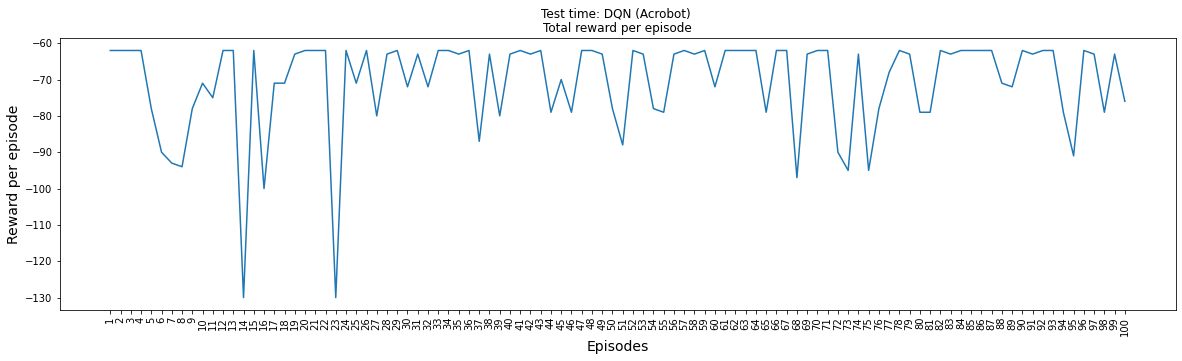

In [45]:
print(f"Average of 100 episodes: {np.mean(test_total_reward_arr)}")
fig = plt.figure(figsize=(20,5))
plt.plot(test_total_reward_arr)
plt.title('Test time: DQN (Acrobot) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.xticks(np.arange(100), np.arange(1,101), rotation=90)
plt.show()

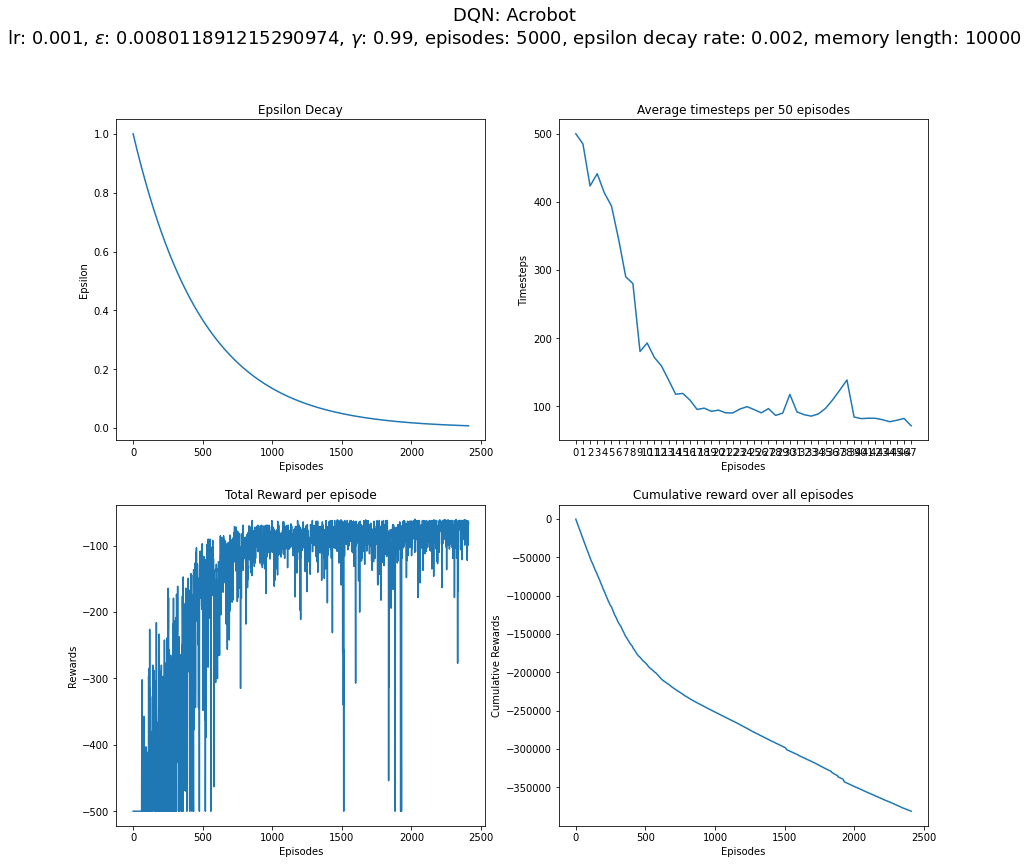

In [41]:
# Plot graphs
title = 'DQN: Acrobot\n' + r'lr: {}, $\epsilon$: {}, $\gamma$: {}, episodes: {}, epsilon decay rate: {}, memory length: {}'.format(lr, epsilon, discount_factor, episodes, epsilon_decay, memory_len)

plot_graphs(title, total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, episodes)

Average of 100 episodes: -70.04


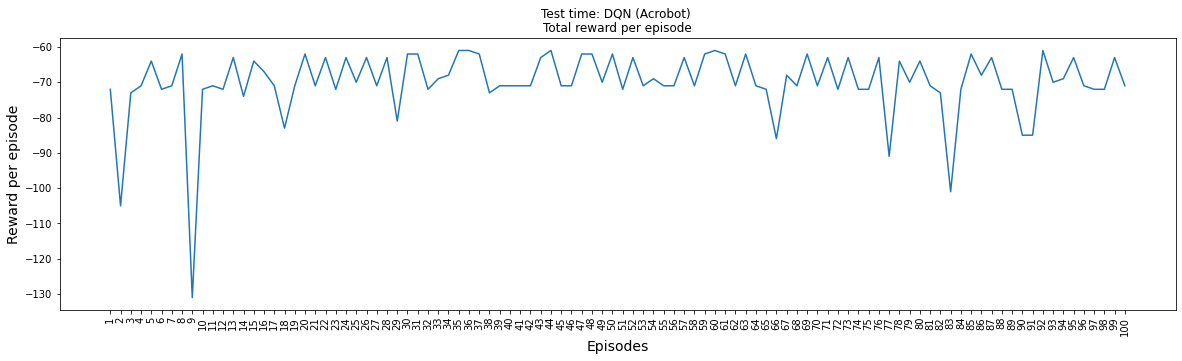

In [42]:
print(f"Average of 100 episodes: {np.mean(test_total_reward_arr)}")
fig = plt.figure(figsize=(20,5))
plt.plot(test_total_reward_arr)
plt.title('Test time: DQN (Acrobot) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.xticks(np.arange(100), np.arange(1,101), rotation=90)
plt.show()

In [ ]:
test_total_reward_arr = agent.test_model(env, test_episodes, perform_render=perform_render)

Average of 100 episodes: -77.52


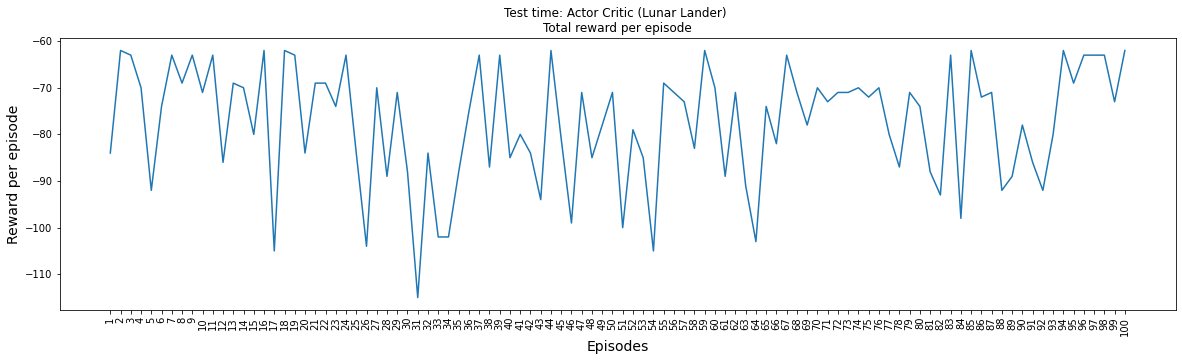

In [13]:
print(f"Average of 100 episodes: {np.mean(test_total_reward_arr)}")
fig = plt.figure(figsize=(20,5))
plt.plot(test_total_reward_arr)
plt.title('Test time: Actor Critic (Lunar Lander) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.xticks(np.arange(100), np.arange(1,101), rotation=90)
plt.show()